In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

## 1. Q-learning in the wild (3 pts)

Here we use the qlearning agent on taxi env from openai gym.
You will need to insert a few agent functions here.

In [2]:
import random
import math
import numpy as np
from collections import defaultdict

def flipCoin(p):
  r = random.random()
  return r < p 


class QLearningAgent():
  """
    Q-Learning Agent

    Instance variables you have access to
      - self.epsilon (exploration prob)
      - self.alpha (learning rate)
      - self.discount (discount rate aka gamma)

    Functions you should use
      - self.getLegalActions(state)
        which returns legal actions for a state
      - self.getQValue(state,action)
        which returns Q(state,action)
      - self.setQValue(state,action,value)
        which sets Q(state,action) := value

    !!!Important!!!
    NOTE: please avoid using self._qValues directly to make code cleaner
  """
  def __init__(self,alpha,epsilon,discount,getLegalActions):
    "We initialize agent and Q-values here."
    self.getLegalActions= getLegalActions
    self._qValues = defaultdict(lambda:defaultdict(lambda:0))
    self.alpha = alpha
    self.epsilon = epsilon
    self.discount = discount

  def getQValue(self, state, action):
    #print(state)
    #print(action)
    if not (state in self._qValues) or not (action in self._qValues[state]):
        return 0.0
    return self._qValues[state][action]

  def setQValue(self,state,action,value):
    """
      Sets the Qvalue for [state,action] to the given value
    """
    self._qValues[state][action] = value

#---------------------#start of your code#---------------------#

  def getValue(self, state):
    """
      Returns max_action Q(state,action)
      where the max is over legal actions.
    """

    possibleActions = self.getLegalActions(state)

    if len(possibleActions) == 0:
        return 0.0

    return max(self.getQValue(state, action) for action in possibleActions)

  def getPolicy(self, state):
    """
      Compute the best action to take in a state.

    """
    possibleActions = self.getLegalActions(state)

    if len(possibleActions) == 0:
        return None

    values = [self.getQValue(state, action) for action in possibleActions]

    return possibleActions[np.argmax(values)]

  def getAction(self, state):
    """
      Compute the action to take in the current state, including exploration.

      With probability self.epsilon, we should take a random action.
      otherwise - the best policy action (self.getPolicy).

      HINT: You might want to use util.flipCoin(prob)
      HINT: To pick randomly from a list, use random.choice(list)

    """

    # Pick Action

    #If there are no legal actions, return None

    #choose action with epsilon exploration strategy:

    possibleActions = self.getLegalActions(state)

    if len(possibleActions) == 0:
        return None
    
    if flipCoin(self.epsilon):
        return random.choice(possibleActions)
    
    return self.getPolicy(state)


  def update(self, state, action, nextState, reward):
    """
      You should do your Q-Value update here

      NOTE: You should never call this function,
      it will be called on your behalf


    """
    #agent parameters
    gamma = self.discount
    learning_rate = self.alpha

    "*** YOUR CODE HERE ***"
    self.setQValue(state, action, self.getQValue(state, action) + learning_rate * (reward + gamma * self.getValue(nextState) - self.getQValue(state, action)))

In [3]:
import gym
env = gym.make("Taxi-v3")
n_actions = env.action_space.n

In [4]:
def play_and_train(env,agent,t_max=10**4):
    """This function should
    - run a full game, actions given by agent.getAction(s)
    - train agent using agent.update(...) whenever possible
    - return total reward"""
    total_reward = 0.0
    state = env.reset()

    for t in range(t_max):
        action = agent.getAction(state)

        next_state, reward, done, _ = env.step(action)

        #<train(update) agent for state s>
        agent.update(state, action, next_state, reward)

        state = next_state
        total_reward += reward
        if done:
            break

    return total_reward

Достигните положительной награды, постройте график

2.54
0.024547096107650827


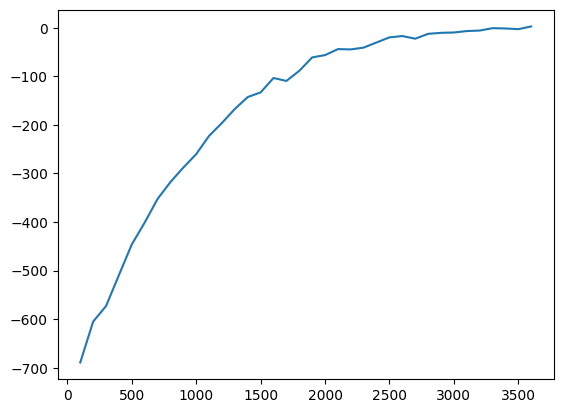

In [16]:
from IPython.display import clear_output
agent = QLearningAgent(alpha=0.03,epsilon=0.9,discount=0.95,
                       getLegalActions = lambda s: range(n_actions))
rewards = []
buffer = []
ax = []

block_size = 100

for i in range((int)(5e4)):
    if i % block_size == 0 and i > 0:
        rewards.append(np.mean(buffer))
        ax.append(i)
        if np.mean(buffer) > 0:
            break
        buffer = []
    buffer.append(play_and_train(env,agent))
    agent.epsilon *= 0.999
    if i % block_size == 0:
        clear_output(True)
        print(agent.epsilon)
        plt.plot(ax, rewards)
        plt.show()

clear_output(True)
print(rewards[-1])
print(agent.epsilon)
plt.plot(ax, rewards)
plt.show()

Вообщем там график наград дико прыгал, поэтому я немного усреднил значения и смотрел на среднее значение последних 100 игр. И если это среднее значение больше нуля, то модель обучилась. Иначе в некоторых играх нам могло везти и мы слишком быстро приходили к положительной награде, но модель не дообучалась при этом.

## 3. Continuous state space (2 pt)

Чтобы использовать табличный q-learning на continuous состояниях, надо как-то их обрабатывать и бинаризовать. Придумайте способ разбивки на дискретные состояния.

In [5]:
env = gym.make("CartPole-v0")
n_actions = env.action_space.n
# print("first state:%s"%(env.reset()))

C:\Users\vinik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gym\envs\registration.py:578: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version v1 with the environment ID `CartPole-v1`.
  logger.warn(


### Play a few games

Постройте распределения различных частей состояния игры. Сыграйте несколько игр и запишите все состояния.

In [18]:
states = []

def play_and_train_without_agent(env,t_max=10**4):
    """This function should
    - run a full game, actions given by agent.getAction(s)
    - train agent using agent.update(...) whenever possible
    - return total reward"""
    total_reward = 0.0
    state = env.reset()

    for t in range(t_max):
        action = np.random.choice(np.arange(n_actions))

        next_state, reward, done, _ = env.step(action)

        state = next_state
        total_reward += reward

        states.append(state)

        if done:
            break

    return total_reward

In [19]:
for _ in range((int)(1e4)):
    play_and_train_without_agent(env)

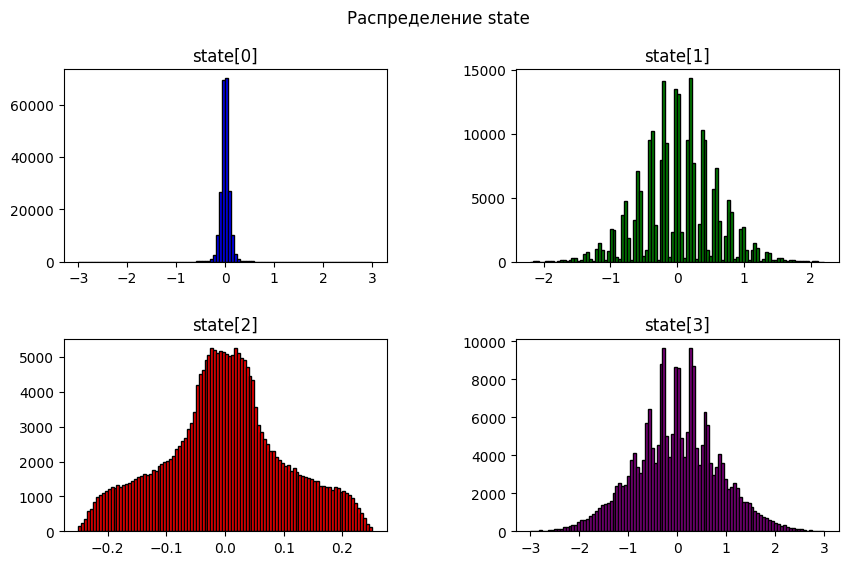

In [40]:
import matplotlib.pyplot as plt # трум трум трум заводись мой баратрум, глоток и я уже лечу заканчивать эту игруууу
# Построим распределение данных по отдельности (для 4-х измерений state)

s0 = []
s1 = []
s2 = []
s3 = []

for v in states:
    s0.append(v[0])
    s1.append(v[1])
    s2.append(v[2])
    s3.append(v[3])

s0 = sorted(s0)
s1 = sorted(s1)
s2 = sorted(s2)
s3 = sorted(s3)

num_bins = 100

fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes[0, 0].hist(s0, bins=num_bins, range=(-3, 3), edgecolor='black', color='blue')
axes[0, 0].set_title('state[0]')

axes[0, 1].hist(s1, bins=num_bins, range=(-2.2, 2.2), edgecolor='black', color='green')
axes[0, 1].set_title('state[1]')

axes[1, 0].hist(s2, bins=num_bins, range=(-0.25, 0.25), edgecolor='black', color='red')
axes[1, 0].set_title('state[2]')

axes[1, 1].hist(s3, bins=num_bins, range=(-3, 3), edgecolor='black', color='purple')
axes[1, 1].set_title('state[3]')


plt.subplots_adjust(wspace=0.4, hspace=0.4)  # Расстояние между подграфиками
plt.suptitle('Распределение state')

plt.show()

Посмотрев на эти значения, видим, что state[0] точно лежит на [-5;5], state[1] на [-3;3], state[2] на [-0.3;0.3], state[3] на [-3;3], давайте разобъем каждый из state[i] на bins равных частей, и так сделаем бинаризацию.

## Binarize environment

In [6]:
from gym.core import ObservationWrapper
import bisect

class Binarizer(ObservationWrapper):

    def to_bin(self, value, bins, l, r):

        where = np.digitize(value, np.linspace(l, r, bins))

        return where

    def observation(self,state):
        state = (self.to_bin(state[0], 25, -5, 5), self.to_bin(state[1], 30, -3, 3), self.to_bin(state[2], 25, -0.21, 0.21), self.to_bin(state[3], 15, -3, 3))

        return state

## Learn

In [100]:
env = Binarizer(gym.make("CartPole-v0"))
agent = QLearningAgent(alpha=0.01,epsilon=0.9,discount=0.96,
                       getLegalActions = lambda s: range(n_actions))

Win!


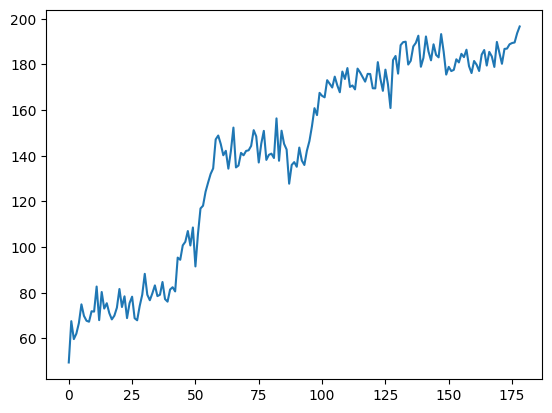

In [101]:
rewards = []
rewBuf = []
ax = []

for i in range(10000):
    for _ in range(100):
        play_and_train(env,agent)
        agent.epsilon *= 0.9999

    was = agent.epsilon

    agent.epsilon = 0
    for _ in range(100):
        rewards.append(play_and_train(env,agent))
    agent.epsilon = was

    ax.append(i)
    rewBuf.append(np.mean(rewards[-100:]))
    print(agent.epsilon)
    if i % 1 == 0:
        clear_output(True)
        plt.plot(ax, rewBuf)
        if(rewBuf[-1] > 195):
            print("Win!")
            break
        plt.show()    
    if(rewBuf[-1] > 195):
        print("Win!")
        break


Для того, чтобы моделька победила (то есть набрала счет больше 195) пришлось знатно так поперебирать разные learning_rate, discount, epsilon, а также в бинаризаторе то, на сколько частей разбиваем плоскость (то есть гиперпараметры), но все же он смог это сделать. Вероятно есть более умный способ их нормально найти, но я его не знаю.

## 4. Experience replay (5 pts)

In [7]:
import random
class ReplayBuffer(object):
    def __init__(self, size):
        """Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
        """
        self._storage = []
        self._maxsize = size
        self._replaceId = 0


    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        '''
        Make sure, _storage will not exceed _maxsize.
        '''
        data = (obs_t, action, reward, obs_tp1, done)
        if len(self._storage) == self._maxsize:
            self._storage[self._replaceId] = data
            self._replaceId += 1
            if self._replaceId == self._maxsize:
                self._replaceId = 0
        else:
            self._storage.append(data)

    def sample(self, batch_size):
        if batch_size > len(self._storage):
            batch_size = len(self._storage)
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """

        batch = random.sample(range(0, len(self._storage)), batch_size)

        obs_batch = []
        act_batch = []
        rew_batch = []
        next_obs_batch = []
        done_mask = []

        for v in batch:
            obs_t, action, reward, obs_next, done = self._storage[v]
            obs_batch.append(obs_t)
            act_batch.append(action)
            rew_batch.append(reward)
            next_obs_batch.append(obs_next)
            done_mask.append(done)

        if batch_size == 1:
            return obs_batch[0], act_batch[0], rew_batch[0], next_obs_batch[0], done_mask[0] # ????

        return obs_batch, act_batch, rew_batch, next_obs_batch, done_mask


Some tests to make sure your buffer works right

In [8]:
import numpy as np
replay = ReplayBuffer(2)
obj1 = tuple(range(5))
obj2 = tuple(range(5, 10))
replay.add(*obj1)
# print(replay.sample(1))
assert replay.sample(1)==obj1, "If there's just one object in buffer, it must be retrieved by buf.sample(1)"
replay.add(*obj2)
assert len(replay._storage)==2, "Please make sure __len__ methods works as intended."
replay.add(*obj2)
assert len(replay._storage)==2, "When buffer is at max capacity, replace objects instead of adding new ones."
assert tuple(np.unique(a) for a in replay.sample(100))==obj2
replay.add(*obj1)
assert max(len(np.unique(a)) for a in replay.sample(100))==2
replay.add(*obj1)
assert tuple(np.unique(a) for a in replay.sample(100))==obj1
print ("Success!")

Success!


Now let's use this buffer to improve training:

In [9]:
import gym
env = Binarizer(gym.make('CartPole-v0'))
n_actions = env.action_space.n

In [10]:
replay = ReplayBuffer(10000)

In [21]:
def play_and_train_replay(env, agent, t_max=10**4, batch_size=10):
    """This function should
    - run a full game, actions given by agent.getAction(s)
    - train agent using agent.update(...) whenever possible
    - return total reward"""
    total_reward = 0.0
    state = env.reset()
    replay._storage.clear()

    for t in range(t_max):
        lol = agent.getAction(state)
        next_state, reward, done, _ = env.step(lol)

        #заполните реплей

        replay.add(state, lol, reward, next_state, done)

        #опционально - моежте также как в варианте без реплея обучаться по состояниям которые


        agent.update(state, lol, next_state, reward)

        state = next_state
        total_reward += reward
        if done:
            break

    #learn from replay

    learn = replay.sample(batch_size)

    state, action, reward, next_state, done = learn

    for i in range(len(state)):
         agent.update(state[i], action[i], next_state[i], reward[i])

    return total_reward


Train with experience replay

0.13448385161819645


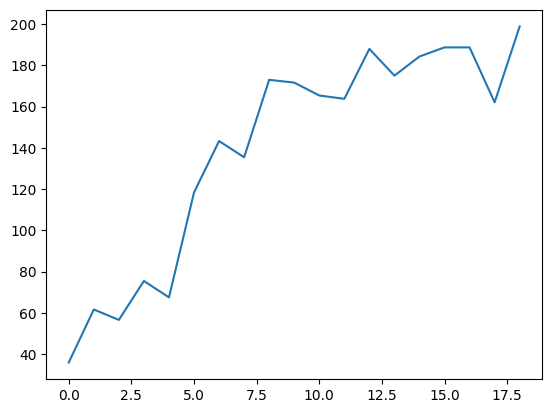

Win!


In [22]:
rewards = []
rewBuf = []
ax = []

agent1 = QLearningAgent(alpha=0.1,epsilon=0.9,discount=0.96,
                       getLegalActions = lambda s: range(n_actions))

for i in range(10000):
    for _ in range(100):
        play_and_train_replay(env, agent1)
        agent1.epsilon *= 0.999

    was = agent1.epsilon

    agent1.epsilon = 0
    for _ in range(100):
        rewards.append(play_and_train_replay(env, agent1))
    agent1.epsilon = was

    ax.append(i)
    rewBuf.append(np.mean(rewards[-100:]))
    clear_output(True)
    print(agent1.epsilon)
    plt.plot(ax, rewBuf)
    plt.show()    
    if(rewBuf[-1] > 195):
        print("Win!")
        break



С запоминанием реплеев модель также смогла победить. Expirience реплеи положительно влияют на скорость обучения (18 итераций против 180). Правда у меня возникали некоторые трудности с нормальной реализацией Binarizer, но вроде получилось нормально.